# Part B: Exploration + Data Preprocessing

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

pd.set_option('display.max_columns', None)

Booking data treatment

In [72]:
original_booking_data = pd.read_csv('scraped_data/booking_data.csv')
original_booking_data.head(3)

print(f'Shape for booking data: {original_booking_data.shape}')
print(f'Nulls before eliminating: \n{original_booking_data.isnull().sum()}')

booking_data = original_booking_data.drop(['Card Deal'], axis=1) # Decided to eliminate this column since more than 80% of the data is missing
booking_data = booking_data[booking_data['Payment Policy'].notnull()]
booking_data = booking_data[booking_data['Cancellation Policy'].notnull()]
booking_data = booking_data[booking_data['Bed Type'].notnull()]

print(f'\nNulls after treatment: {booking_data.isnull().sum().sum()}')
print(f'Shape for booking data after treatment: {booking_data.shape}')

booking_data['Date of search'] = pd.to_datetime(booking_data['Date of search'])
booking_data['Checkin'] = pd.to_datetime(booking_data['Checkin'])
booking_data['Checkout'] = pd.to_datetime(booking_data['Checkout'])

booking_data = booking_data.reset_index(drop=True)

booking_data.head(2)

Shape for booking data: (11941, 22)
Nulls before eliminating: 
Hotel Name                0
Score                     0
Distance to Center        0
Price                     0
Taxes and Fees            0
Total Price               0
Nights and Adults         0
Card Deal              9410
Stars                   537
Subway Access             0
Neighborhood              0
Room Type                 0
Bed Type                  5
Cancellation Policy    4461
Payment Policy         9760
Classification            0
Number of Reviews         0
Date of search            0
Checkin                   0
Checkout                  0
ttt                       0
los                       0
dtype: int64

Nulls after treatment: 0
Shape for booking data after treatment: (2181, 21)


,Hotel Name,Score,Distance to Center,Price,Taxes and Fees,Total Price,Nights and Adults,Stars,Subway Access,Neighborhood,Room Type,Bed Type,Cancellation Policy,Payment Policy,Classification,Number of Reviews,Date of search,Checkin,Checkout,ttt,los
0,SpringHill Suites by Marriott New York Midtown...,8.1,1.9,279,45,324.0,"1 night,2 adults",3.0,True,Manhattan,King Studio,Entire studio•1 bathroom•18m²,Free cancellation,No prepayment needed– pay at the property,Very Good,1027,2024-06-20,2024-06-21,2024-06-22,1,1
1,Hilton Club The Central at 5th New York,8.9,1.3,1410,211,1621.0,"1 night,2 adults",3.0,True,Midtown East,One-Bedroom Premier King Suite with Sofa Bed,Private suite,Free cancellation,No prepayment needed– pay at the property,Excellent,607,2024-06-20,2024-06-21,2024-06-22,1,1


Expedia data treatment

In [73]:
original_expedia_data = pd.read_csv('scraped_data/expedia_data.csv')

print(f'Shape for expedia data: {original_expedia_data.shape}')
print(f'Nulls before eliminating: \n{original_expedia_data.isnull().sum()}')

expedia_data = original_expedia_data.drop(columns=['Room Type', 'Bed Type'], axis=1) # TEMPORARY, THE CODE IS NOT RETRIEVING THIS WELL
expedia_data = expedia_data.dropna(subset=['Cancellation Policy', 'Payment Policy', 'Classification'])

print(f'\nNulls after treatment: {expedia_data.isnull().sum().sum()}')
print(f'Shape for expedia after treatment: {expedia_data.shape}')
expedia_data['Date of search'] = pd.to_datetime(expedia_data['Date of search'])
expedia_data['Checkin'] = pd.to_datetime(expedia_data['Checkin'])
expedia_data['Checkout'] = pd.to_datetime(expedia_data['Checkout'])

expedia_data['Total Price'] = expedia_data['Total Price'].replace(',', '', regex=True).astype(int)

# Changing column names for both booking and expedia
new_expedia_columns = [column.replace(' ', '_').lower() for column in expedia_data.columns]
new_booking_columns = [column.replace(' ', '_').lower() for column in booking_data.columns]

expedia_data.columns = new_expedia_columns
booking_data.columns = new_booking_columns

expedia_data = expedia_data.reset_index(drop=True)

expedia_data.head(2)

Shape for expedia data: (38777, 17)
Nulls before eliminating: 
Hotel Name                 0
Price Before Taxes         0
Score                      0
Classification            35
Number of Reviews          0
Room Type              38777
Bed Type               38777
Neighborhood               0
District                   0
Cancellation Policy    26220
Payment Policy         31651
Total Price                0
Date of search             0
Checkin                    0
Checkout                   0
ttt                        0
los                        0
dtype: int64

Nulls after treatment: 0
Shape for expedia after treatment: (7126, 15)


C:\Users\User\AppData\Local\Temp\ipykernel_19920\3556764346.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  original_expedia_data = pd.read_csv('scraped_data/expedia_data.csv')


,hotel_name,price_before_taxes,score,classification,number_of_reviews,neighborhood,district,cancellation_policy,payment_policy,total_price,date_of_search,checkin,checkout,ttt,los
0,Moxy NYC Chelsea,220,8.6,Excellent,1002,Chelsea,Chelsea,Fully refundable,Fully refundable,286,2024-06-20,2024-06-21,2024-06-22,1,1
1,Moxy NYC Chelsea,220,8.6,Excellent,1002,Chelsea,Chelsea,Fully refundable,Fully refundable,286,2024-06-20,2024-06-21,2024-06-23,1,2


In [74]:
print(f'Expedia data columns: {expedia_data.columns}')
print(f'Booking data columns: {booking_data.columns}')

Expedia data columns: Index(['hotel_name', 'price_before_taxes', 'score', 'classification',
       'number_of_reviews', 'neighborhood', 'district', 'cancellation_policy',
       'payment_policy', 'total_price', 'date_of_search', 'checkin',
       'checkout', 'ttt', 'los'],
      dtype='object')
Booking data columns: Index(['hotel_name', 'score', 'distance_to_center', 'price', 'taxes_and_fees',
       'total_price', 'nights_and_adults', 'stars', 'subway_access',
       'neighborhood', 'room_type', 'bed_type', 'cancellation_policy',
       'payment_policy', 'classification', 'number_of_reviews',
       'date_of_search', 'checkin', 'checkout', 'ttt', 'los'],
      dtype='object')


- Creating for both expedia and booking data distribution graphs of:
1. Number of reviews
2. Hotel rating in reviews
3. Prices

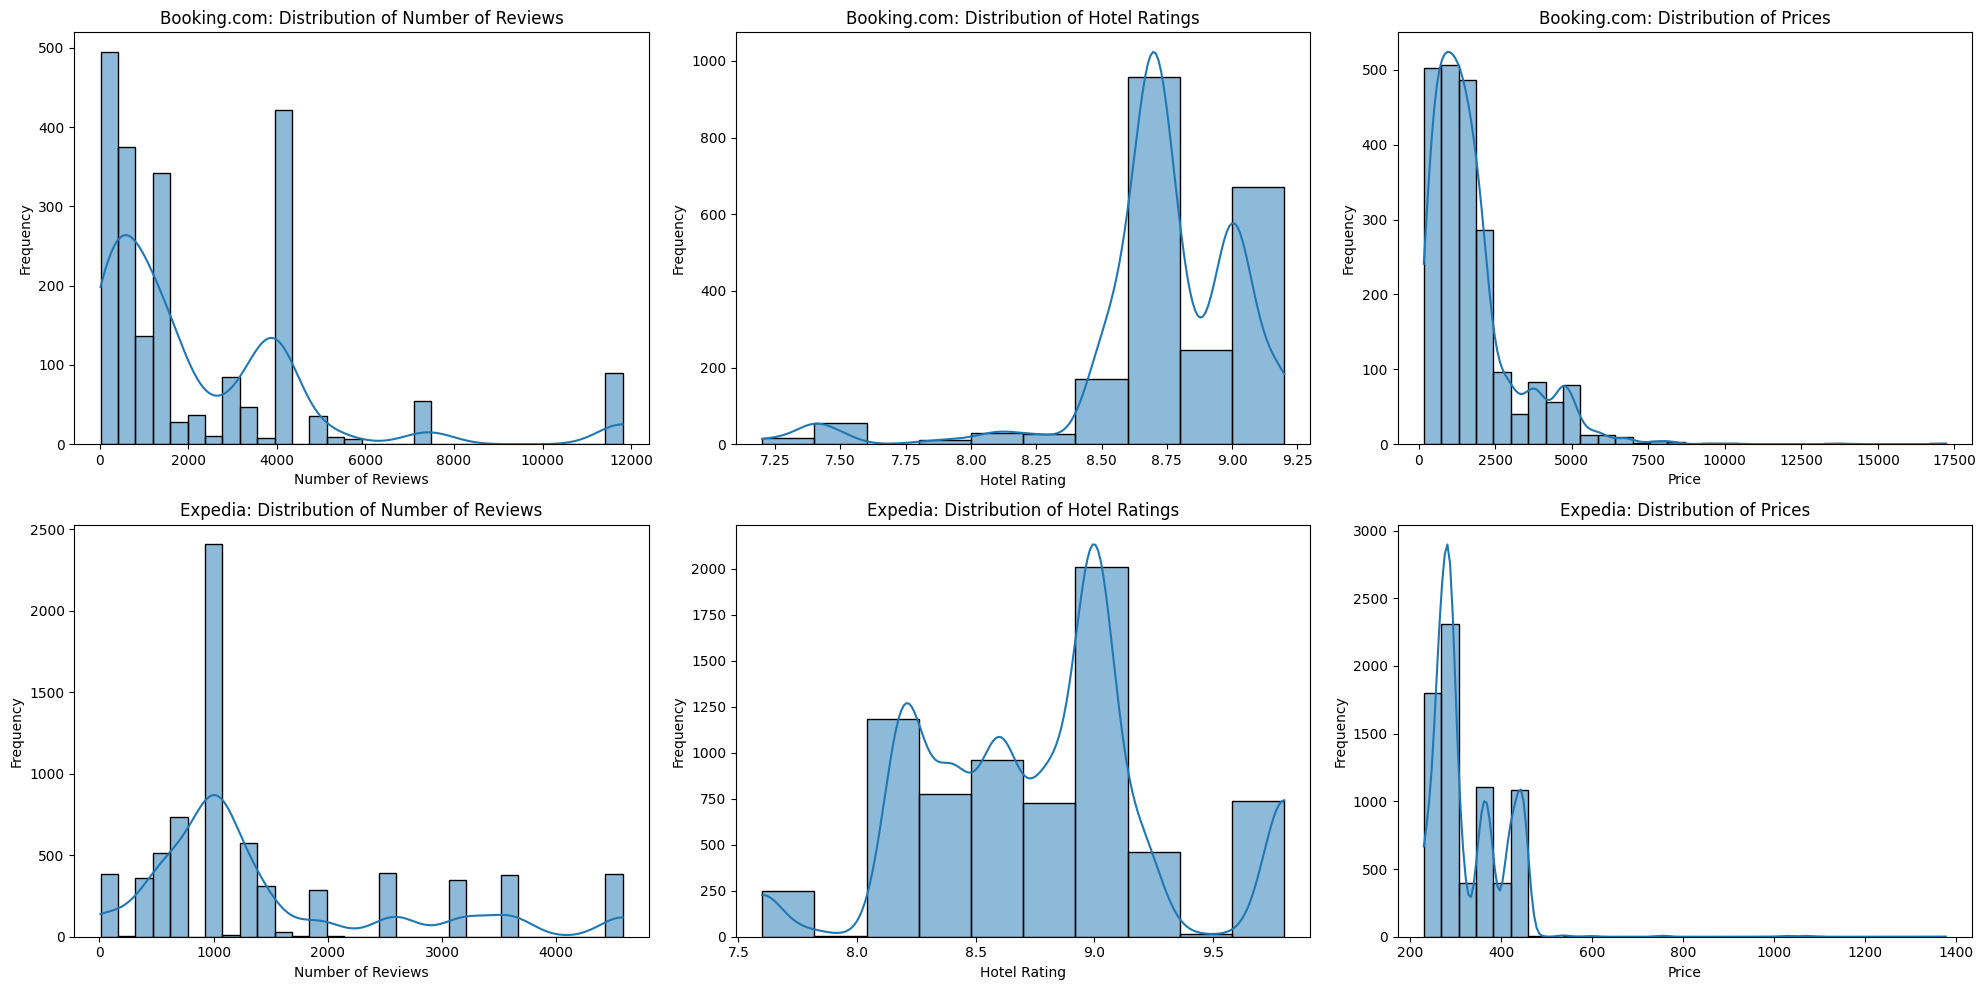

In [75]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Booking.com data plots
# 1. Number of reviews
sns.histplot(booking_data['number_of_reviews'].astype(int), bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Booking.com: Distribution of Number of Reviews')
axs[0, 0].set_xlabel('Number of Reviews')
axs[0, 0].set_ylabel('Frequency')

# 2. Hotel rating in reviews
sns.histplot(booking_data['score'].astype(float), bins=10, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Booking.com: Distribution of Hotel Ratings')
axs[0, 1].set_xlabel('Hotel Rating')
axs[0, 1].set_ylabel('Frequency')

# 3. Prices
sns.histplot(booking_data['total_price'].astype(float), bins=30, kde=True, ax=axs[0, 2])
axs[0, 2].set_title('Booking.com: Distribution of Prices')
axs[0, 2].set_xlabel('Price')
axs[0, 2].set_ylabel('Frequency')

# Expedia data plots
# 1. Number of reviews
sns.histplot(expedia_data['number_of_reviews'].astype(int), bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Expedia: Distribution of Number of Reviews')
axs[1, 0].set_xlabel('Number of Reviews')
axs[1, 0].set_ylabel('Frequency')

# 2. Hotel rating in reviews
sns.histplot(expedia_data['score'].astype(float), bins=10, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Expedia: Distribution of Hotel Ratings')
axs[1, 1].set_xlabel('Hotel Rating')
axs[1, 1].set_ylabel('Frequency')

# 3. Prices
sns.histplot(expedia_data['total_price'].astype(float), bins=30, kde=True, ax=axs[1, 2])
axs[1, 2].set_title('Expedia: Distribution of Prices')
axs[1, 2].set_xlabel('Price')
axs[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

- Remove from data hotels that based on price column are an outlier (using 
Tukey 1.5IQR method).

In [76]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

booking_data_no_outliers = remove_outliers(booking_data, 'total_price')
expedia_data_no_outliers = remove_outliers(expedia_data, 'total_price')

print(f'Booking data shape without outliers: {booking_data_no_outliers.shape}')
print(f'Expedia data shape without outliers: {expedia_data_no_outliers.shape}')

Booking data shape without outliers: (1996, 21)
Expedia data shape without outliers: (7102, 15)


- Convert variables with Ordinal characteristic to numbers with order relation 
(for example Good < Very Good<Excellent)

Booking data

In [77]:
# Change here the values
booking_data_no_outliers = booking_data_no_outliers.copy()
print(f'Unique values for review class before treatment: {booking_data_no_outliers["classification"].unique()}')

# Eliminating all the rows where Review Class column says 'Review score'
booking_data_no_outliers = booking_data_no_outliers[booking_data_no_outliers['classification'] != 'Review score'] # Eliminating all the rows where Review Class column says 'Review score'

ordinal_mapping_booking = {
    'Good': 1,
    'Very Good': 2,
    'Excellent': 3,
    'Wonderful': 4,
}

booking_data_no_outliers['classification'] = booking_data_no_outliers['classification'].map(ordinal_mapping_booking)
print(f'Unique values for review class after treatment: {booking_data_no_outliers["classification"].unique()}')

Unique values for review class before treatment: ['Very Good' 'Excellent' 'Wonderful' 'Good']
Unique values for review class after treatment: [2 3 4 1]


Expedia data

In [78]:
# Make a copy of the DataFrame
expedia_data_no_outliers = expedia_data_no_outliers.copy()
print(f'Unique values for review class before treatment: {expedia_data_no_outliers["classification"].unique()}')

# Eliminating all the rows where Review Class column says 'Review score'
ordinal_mapping_expedia = {
    'Good': 0,
    'Very Good': 1,
    'Excellent': 2,
    'Wonderful': 3,
    'Exceptional': 4,
}
expedia_data_no_outliers['classification'] = expedia_data_no_outliers['classification'].map(ordinal_mapping_expedia)
print(f'Unique values for review class after treatment: {expedia_data_no_outliers["classification"].unique()}')

Unique values for review class before treatment: ['Excellent' 'Very Good' 'Wonderful' 'Exceptional' 'Good']
Unique values for review class after treatment: [2 1 3 4 0]


- Additional example – the bed type by order relation. First you have to 
calculate the bed types (distinct) out of total data you have). And then King 
Room should get higher value then Queen Room for example.

Since there are many different types of beds retrieven from the scraping, I have decided to encode these columns too in the following part of the project requirements.

Booking data

In [79]:
def one_hot_encode(df, columns_to_encode):
    # One-hot encode the columns
    encoder = OneHotEncoder(drop='first')
    encoded_data = encoder.fit_transform(df[columns_to_encode])

    # Get the correct feature names after encoding
    feature_names = encoder.get_feature_names_out(input_features=columns_to_encode)

    # Create a DataFrame with the encoded data and the correct feature names
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=feature_names)

    # Merge with original dataframe
    data = df.drop(columns=columns_to_encode).reset_index(drop=True)
    data = pd.concat([data, encoded_df], axis=1)
    
    return data

# One-hot encode the columns of expedia and booking data
columns_to_encode_booking = ['hotel_name', 'nights_and_adults', 'neighborhood', 'room_type', 'bed_type', 'cancellation_policy', 'payment_policy']
columns_to_encode_expedia = ['hotel_name', 'neighborhood', 'district', 'cancellation_policy', 'payment_policy']

booking_data_encoded = one_hot_encode(booking_data_no_outliers, columns_to_encode_booking)
expedia_data_encoded = one_hot_encode(expedia_data_no_outliers, columns_to_encode_expedia)

print(f'Shape of booking data after encoding: {booking_data_encoded.shape}')
print(f'Shape of expedia data after encoding: {expedia_data_encoded.shape}')

Shape of booking data after encoding: (1996, 191)
Shape of expedia data after encoding: (7102, 66)


- PairGrid (of seaborn library) for the variables in booking and expedia data.

Booking data numerical variables pairplot

In [80]:
# booking_data_columns_pairgrid = ['score', 'distance_to_center', 'price', 'taxes_and_fees', 'stars', 'subway_access', 'classification', 'number_of_reviews', 'total_price']

# # Create a PairGrid object
# grid = sns.PairGrid(data=booking_data_encoded[booking_data_columns_pairgrid])

# # Map a scatter plot to the upper triangle
# grid = grid.map_lower(plt.scatter, color='darkred')

# # Map a KDE plot to the diagonal
# grid = grid.map_diag(sns.kdeplot, lw=2, color='darkred')

# plt.show()

Expedia data numerical variables pairplot

In [81]:
# expedia_data_columns_pairgrid = ['price_before_taxes', 'score', 'classification', 'number_of_reviews', 'total_price']

# # Create a PairGrid object
# grid = sns.PairGrid(data=expedia_data_encoded[expedia_data_columns_pairgrid])

# # Map a scatter plot to the upper triangle
# grid = grid.map_lower(plt.scatter, color='darkred')

# # Map a KDE plot to the diagonal
# grid = grid.map_diag(sns.kdeplot, lw=2, color='darkred')

# plt.show()

# Part C – prediction of rooms prices

In [82]:
booking_data_encoded.isnull().sum()

score                                                             0
distance_to_center                                                0
price                                                             0
taxes_and_fees                                                    0
total_price                                                       0
                                                                 ..
bed_type_Entire studio•1 bathroom•1 kitchen•39m²                  0
bed_type_Entire studio•1 bathroom•18m²                            0
bed_type_Private suite                                            0
bed_type_Private suite•1 bedroom•1 living room•1 bathroom•56m²    0
bed_type_Private suite•1 bedroom•1 living room•1 bathroom•58m²    0
Length: 191, dtype: int64

In [83]:
X_booking = booking_data_encoded.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
X_expedia = expedia_data_encoded.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])

y_booking = booking_data_encoded['total_price']
y_expedia = expedia_data_encoded['total_price']

In [27]:
def plot_residuals(y_train, y_train_pred, y_test, y_test_pred, model_name):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    sns.residplot(x=y_train, y=y_train_pred - y_train, lowess=True, color="g")
    plt.title(f'{model_name} - Train Residuals')
    plt.xlabel('Actual Prices')
    plt.ylabel('Residuals')

    plt.subplot(1, 2, 2)
    sns.residplot(x=y_test, y=y_test_pred - y_test, lowess=True, color="b")
    plt.title(f'{model_name} - Test Residuals')
    plt.xlabel('Actual Prices')
    plt.ylabel('Residuals')

    plt.tight_layout()
    plt.show()

def train_and_evaluate_models(X, y, residual_plots=True, importances=True):
    # Split the data into training and testing sets (70-30 ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize models with hyperparameters to tune
    param_grids = {
        'Linear Regression': {
            'fit_intercept': [True, False],
            'positive': [True, False]
        },
        'Decision Tree': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'criterion': ['absolute_error', 'squared_error']
        },
        'K-Nearest Neighbors': {
            'n_neighbors': [3, 5, 7, 10],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        },
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        },
        'Gradient Boosting': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        },
        'AdaBoost': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1.0]
        }
    }

    # Models dictionary
    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'K-Nearest Neighbors': KNeighborsRegressor(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'AdaBoost': AdaBoostRegressor(random_state=42)
    }

    # Dictionary to store results
    results = {
        'Model': [],
        'Best Params': [],
        'Train RMSE': [],
        'Test RMSE': [],
        'Train MAE': [],
        'Test MAE': [],
        'Train R2': [],
        'Test R2': [],
    }

    # Train, predict and evaluate each model
    for name, model in models.items():
        print(f"Training {name}...")
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        # Calculate error metrics
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)

        # Append results
        results['Model'].append(name)
        results['Best Params'].append(grid_search.best_params_)
        results['Train RMSE'].append(rmse_train)
        results['Test RMSE'].append(rmse_test)
        results['Train MAE'].append(mae_train)
        results['Test MAE'].append(mae_test)
        results['Train R2'].append(r2_train)
        results['Test R2'].append(r2_test)

        # Get feature importances
        if importances:
            if name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
                importances = best_model.feature_importances_
                feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
                results['Feature Importances'].append(feature_importances)
            elif name == 'Linear Regression':
                coefficients = best_model.coef_
                feature_importances = pd.Series(coefficients, index=X.columns).sort_values(ascending=False)
                results['Feature Importances'].append(feature_importances)
            else:
                # Use permutation importance for SVR and AdaBoost
                perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
                feature_importances = pd.Series(perm_importance.importances_mean, index=X.columns).sort_values(ascending=False)
                results['Feature Importances'].append(feature_importances)

        # Plot residuals
        if residual_plots:
            plot_residuals(y_train, y_train_pred, y_test, y_test_pred, name)

    # Convert results to DataFrame and print
    results_df = pd.DataFrame(results)

    return results_df

Training Linear Regression...


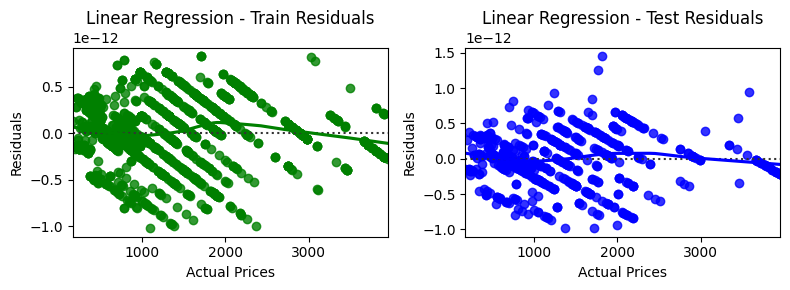

Training Decision Tree...


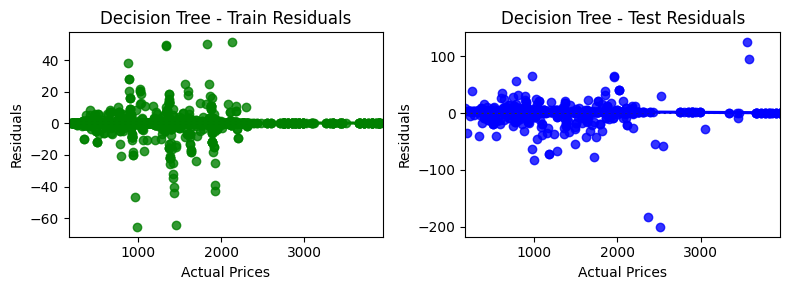

Training K-Nearest Neighbors...


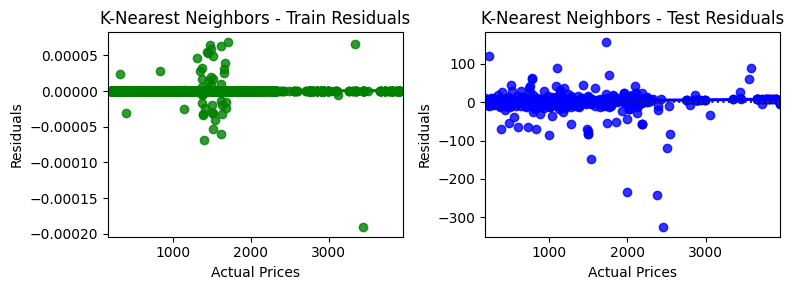

Training Random Forest...


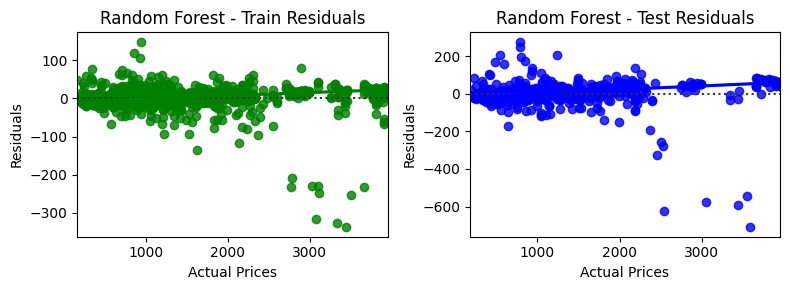

Training Gradient Boosting...


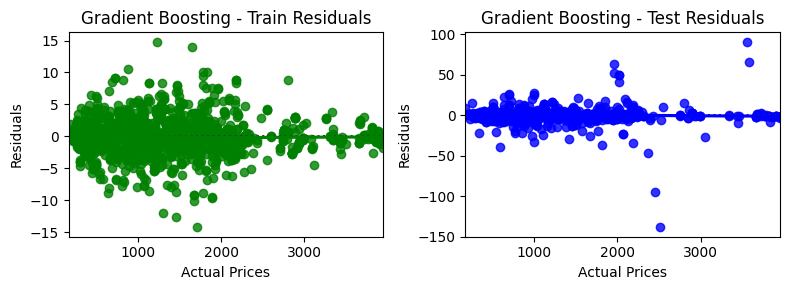

Training AdaBoost...


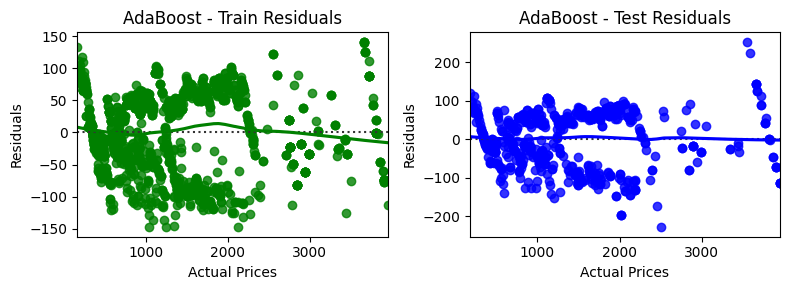

                 Model                                        Best Params  \
0    Linear Regression         {'fit_intercept': False, 'positive': True}   
1        Decision Tree  {'criterion': 'absolute_error', 'max_depth': 1...   
2  K-Nearest Neighbors  {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}   
3        Random Forest  {'max_depth': None, 'max_features': 'sqrt', 'm...   
4    Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
5             AdaBoost        {'learning_rate': 1.0, 'n_estimators': 200}   

     Train RMSE     Test RMSE     Train MAE      Test MAE  Train R2   Test R2  \
0  1.054541e-12  1.038681e-12  8.318996e-13  8.164955e-13  1.000000  1.000000   
1  6.600254e+00  1.957229e+01  2.173944e+00  7.987479e+00  0.999943  0.999485   
2  8.363167e-06  2.814595e+01  1.154178e-06  1.054503e+01  1.000000  0.998934   
3  3.108390e+01  7.932075e+01  1.280676e+01  3.346391e+01  0.998729  0.991535   
4  2.862831e+00  1.223505e+01  2.046531e+00  5.733121e+

In [16]:
results_df_booking = train_and_evaluate_models(X_booking, y_booking)
print(results_df_booking)

In [17]:
# Get the feature importances for the 'Random Forest' model
rf_importances_series = results_df_booking.loc[results_df_booking['Model'] == 'Random Forest', 'Feature Importances'].values[0]

# Convert the Series to a DataFrame
rf_importances_df = rf_importances_series.to_frame()
# Filter the DataFrame

rf_importances_df.columns = ['Importance']
filtered_rf_importances_df = rf_importances_df[rf_importances_df['Importance'] > 0.01]

filtered_rf_importances_df

,Importance
price,0.209146
taxes_and_fees,0.161746
los,0.096183
stars,0.073262
number_of_reviews,0.055321
hotel_name_The St. Regis New York,0.052353
"nights_and_adults_1 night,2 adults",0.048564
room_type_Superior King Room - Butler Service,0.045101
score,0.027585
"nights_and_adults_4 nights,2 adults",0.024857


Training Linear Regression...


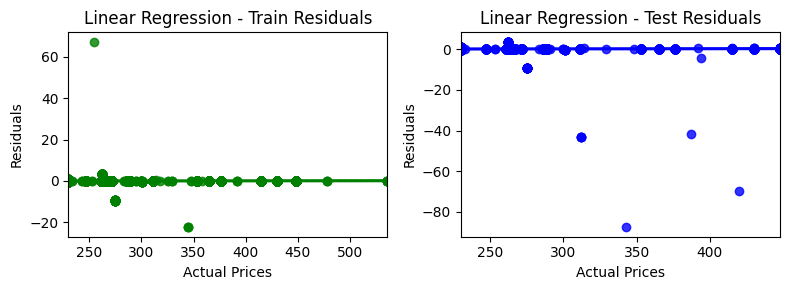

Training Decision Tree...


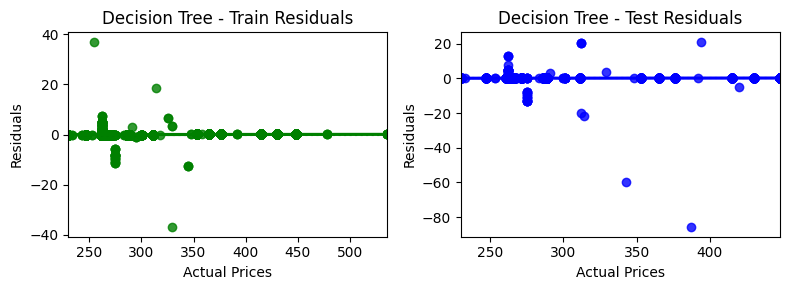

Training K-Nearest Neighbors...


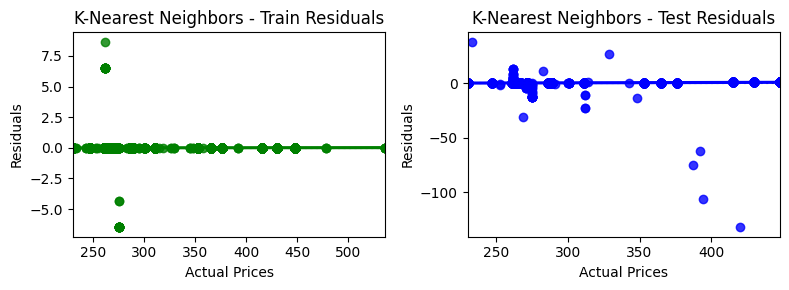

Training Random Forest...


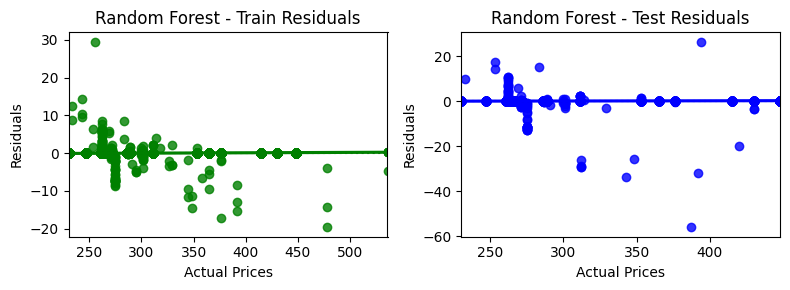

Training Gradient Boosting...


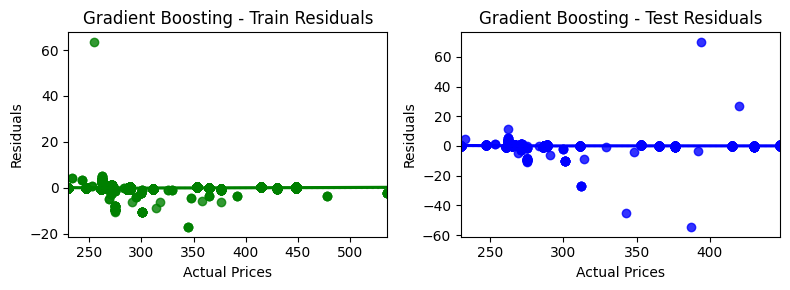

Training AdaBoost...


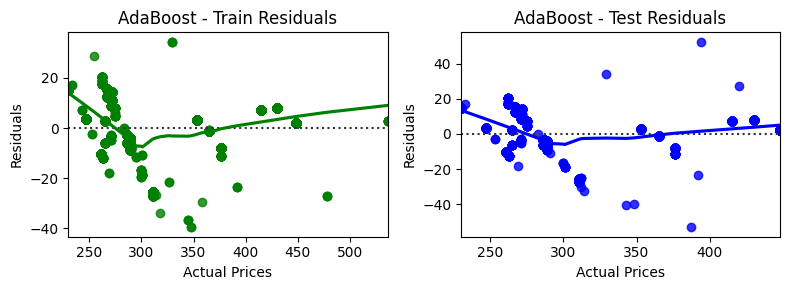

                 Model                                        Best Params  \
0    Linear Regression        {'fit_intercept': False, 'positive': False}   
1        Decision Tree  {'criterion': 'squared_error', 'max_depth': No...   
2  K-Nearest Neighbors  {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}   
3        Random Forest  {'max_depth': None, 'max_features': 'sqrt', 'm...   
4    Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...   
5             AdaBoost        {'learning_rate': 1.0, 'n_estimators': 100}   

   Train RMSE  Test RMSE  Train MAE  Test MAE  Train R2   Test R2  \
0    1.407552   3.380944   0.202868  0.393877  0.999589  0.997496   
1    1.101401   2.774710   0.104382  0.268064  0.999748  0.998314   
2    0.510534   4.695851   0.040099  0.437375  0.999946  0.995170   
3    1.072511   2.590726   0.139992  0.352326  0.999761  0.998530   
4    1.466921   2.824724   0.522410  0.674868  0.999553  0.998252   
5   10.550496  10.908260   7.413923  7.793375 

In [18]:
results_df_expedia =  train_and_evaluate_models(X_expedia, y_expedia)
print(results_df_expedia)

- Suggest new features (that calculated based on existing ones) and check how 
they impact your prediction results. For example maybe you should not only 
take the TTT values but also the day in the week of the check-in, and how 
close it is to the end of month, or to an holiday, etc..

In [19]:
def add_new_features(df):
    # Day of the week feature
    df['checkin_day_of_week'] = df['checkin'].dt.dayofweek
    
    # Proximity to month end feature
    df['days_to_month_end'] = df['checkin'].dt.days_in_month - df['checkin'].dt.day
    
    # Stay duration feature
    df['stay_duration'] = (df['checkout'] - df['checkin']).dt.days
    
    # Weekend stay feature
    df['weekend_stay'] = df.apply(lambda row: int(any(day in [5, 6] for day in pd.date_range(start=row['checkin'], end=row['checkout']).dayofweek)), axis=1)
    
    return df

# Example usage for booking and expedia data
booking_data_enhanced = add_new_features(booking_data_encoded)
expedia_data_enhanced = add_new_features(expedia_data_encoded)

print(f'Shape of booking data after adding new features: {booking_data_enhanced.shape}')
print(f'Shape of expedia data after adding new features: {expedia_data_enhanced.shape}')

Shape of booking data after adding new features: (1996, 195)
Shape of expedia data after adding new features: (7102, 70)


In [20]:
X_booking_enhanced = booking_data_enhanced.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
X_expedia_enhanced = expedia_data_enhanced.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])

print(f'Booking training of the models with the new feautures...')
results_df_booking_enhanced = train_and_evaluate_models(X_booking_enhanced, y_booking, residual_plots=False)
print(f'\nExpedia training of the models with the new feautures...')
results_df_expedia_enhanced = train_and_evaluate_models(X_expedia_enhanced, y_expedia, residual_plots=False)

print(results_df_booking_enhanced)
print(results_df_expedia_enhanced)

Booking training of the models with the new feautures...
Training Linear Regression...
Training Decision Tree...
Training K-Nearest Neighbors...
Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...
Training Linear Regression...
Training Decision Tree...
Training K-Nearest Neighbors...
Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...

Expedia training of the models with the new feautures...
                 Model                                        Best Params  \
0    Linear Regression         {'fit_intercept': False, 'positive': True}   
1        Decision Tree  {'criterion': 'squared_error', 'max_depth': No...   
2  K-Nearest Neighbors  {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}   
3        Random Forest  {'max_depth': 30, 'max_features': 'sqrt', 'min...   
4    Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
5             AdaBoost        {'learning_rate': 1.0, 'n_estimators': 200}   

     Train RMSE

Normalization of the data

In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def normalize_min_max(df, columns):
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

def normalize_standard(df, columns):
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

def normalize_robust(df, columns):
    scaler = RobustScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

def apply_normalization(df, columns):
    # Apply Min-Max Scaling
    df_min_max = df.copy()
    df_min_max = normalize_min_max(df_min_max, columns)
    
    # Apply Standardization
    df_standard = df.copy()
    df_standard = normalize_standard(df_standard, columns)
    
    # Apply Robust Scaling
    df_robust = df.copy()
    df_robust = normalize_robust(df_robust, columns)
    
    return df_min_max, df_standard, df_robust

In [23]:
# List of numerical columns for Expedia and Booking datasets
numerical_columns_expedia = ['price_before_taxes', 'score', 'number_of_reviews', 'total_price', 'ttt', 'los']
numerical_columns_booking = ['score', 'distance_to_center', 'total_price', 'taxes_and_fees', 'stars', 'number_of_reviews', 'ttt', 'los']

# Assuming expedia_data_encoded and booking_data_encoded are the dataframes with encoded categorical variables
expedia_data_min_max, expedia_data_standard, expedia_data_robust = apply_normalization(expedia_data_encoded, numerical_columns_expedia)
booking_data_min_max, booking_data_standard, booking_data_robust = apply_normalization(booking_data_encoded, numerical_columns_booking)

Shape of Expedia data after Min-Max scaling: (7102, 70)
Shape of Expedia data after Standard scaling: (7102, 70)
Shape of Expedia data after Robust scaling: (7102, 70)
Shape of Booking data after Min-Max scaling: (1996, 195)
Shape of Booking data after Standard scaling: (1996, 195)
Shape of Booking data after Robust scaling: (1996, 195)


In [24]:
X_booking_normalized_min_max = booking_data_min_max.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
X_expedia_normalized_min_max = expedia_data_min_max.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
y_booking_min_max = booking_data_min_max['total_price']
y_expedia_min_max = expedia_data_min_max['total_price']

X_booking_normalized_standard = booking_data_standard.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
X_expedia_normalized_standard = expedia_data_standard.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
y_booking_standard = booking_data_standard['total_price']
y_expedia_standard = expedia_data_standard['total_price']

X_booking_normalized_robust = booking_data_robust.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
X_expedia_normalized_robust = expedia_data_robust.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
y_booking_robust = booking_data_robust['total_price']
y_expedia_robust = expedia_data_robust['total_price']

In [28]:
print(f'Booking training of the models with the new feautures...')
results_df_booking_min_max = train_and_evaluate_models(X_booking_normalized_min_max, y_booking_min_max, residual_plots=False, importances=False)
print(f'\nExpedia training of the models with the new feautures...')
results_df_expedia_min_max = train_and_evaluate_models(X_expedia_normalized_min_max, y_expedia_min_max, residual_plots=False, importances=False)

print(results_df_booking_min_max)
print(results_df_expedia_min_max)

Booking training of the models with the new feautures...
Training Linear Regression...
Training Decision Tree...
Training K-Nearest Neighbors...
Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...
Training Linear Regression...
Training Decision Tree...
Training K-Nearest Neighbors...
Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...

Expedia training of the models with the new feautures...
                 Model                                        Best Params  \
0    Linear Regression         {'fit_intercept': True, 'positive': False}   
1        Decision Tree  {'criterion': 'absolute_error', 'max_depth': 1...   
2  K-Nearest Neighbors  {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}   
3        Random Forest  {'max_depth': 20, 'max_features': 'sqrt', 'min...   
4    Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
5             AdaBoost        {'learning_rate': 1.0, 'n_estimators': 200}   

     Train RMSE

In [29]:
print(f'Booking training of the models with the new feautures...')
results_df_booking_standard = train_and_evaluate_models(X_booking_normalized_standard, y_booking_standard, residual_plots=False, importances=False)
print(f'\nExpedia training of the models with the new feautures...')
results_df_expedia_standard = train_and_evaluate_models(X_expedia_normalized_standard, y_expedia_standard, residual_plots=False, importances=False)

print(results_df_booking_standard)
print(results_df_expedia_standard)

Booking training of the models with the new feautures...
Training Linear Regression...
Training Decision Tree...
Training K-Nearest Neighbors...
Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...
Training Linear Regression...
Training Decision Tree...
Training K-Nearest Neighbors...
Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...

Expedia training of the models with the new feautures...
                 Model                                        Best Params  \
0    Linear Regression         {'fit_intercept': True, 'positive': False}   
1        Decision Tree  {'criterion': 'squared_error', 'max_depth': No...   
2  K-Nearest Neighbors  {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}   
3        Random Forest  {'max_depth': 30, 'max_features': 'sqrt', 'min...   
4    Gradient Boosting  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...   
5             AdaBoost        {'learning_rate': 1.0, 'n_estimators': 200}   

     Train RMSE

In [30]:
print(f'Booking training of the models with the new feautures...')
results_df_booking_robust = train_and_evaluate_models(X_booking_normalized_robust, y_booking_robust, residual_plots=False, importances=False)
print(f'\nExpedia training of the models with the new feautures...')
results_df_expedia_robust = train_and_evaluate_models(X_expedia_normalized_robust, y_expedia_robust, residual_plots=False, importances=False)

print(results_df_booking_robust)
print(results_df_expedia_robust)

Booking training of the models with the new feautures...
Training Linear Regression...
Training Decision Tree...
Training K-Nearest Neighbors...
Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...
Training Linear Regression...
Training Decision Tree...
Training K-Nearest Neighbors...
Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...

Expedia training of the models with the new feautures...
                 Model                                        Best Params  \
0    Linear Regression         {'fit_intercept': True, 'positive': False}   
1        Decision Tree  {'criterion': 'squared_error', 'max_depth': 10...   
2  K-Nearest Neighbors  {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}   
3        Random Forest  {'max_depth': None, 'max_features': 'sqrt', 'm...   
4    Gradient Boosting  {'learning_rate': 0.2, 'max_depth': 5, 'n_esti...   
5             AdaBoost        {'learning_rate': 1.0, 'n_estimators': 200}   

     Train RMSE

In [32]:
results_df_booking_robust['Best Params'][4]

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}

- Show a graph that show the distribution of R2 errors of your best model 
across the different hotels.

- Perform the experiment again using the best algorithm you got – this time on 
different split of Train and Test:
1. The Train will contain the data for TTT<=25
2. The Test will contain the data for TTT>25 (this way we basically check the 
ability to predict the prices in the “future”).

In [106]:
# # Normalization functions
# def normalize_robust(df, columns):
#     scaler = RobustScaler()
#     df[columns] = scaler.fit_transform(df[columns])
#     return df

# # Model training and evaluation function
# def train_and_evaluate_best_model(X_train, y_train, X_test, y_test):
#     # Define the best model with its hyperparameters
#     best_model = GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=200, random_state=42)
    
#     # Train the model
#     best_model.fit(X_train, y_train)
    
#     # Predict on both train and test sets
#     y_train_pred = best_model.predict(X_train)
#     y_test_pred = best_model.predict(X_test)
    
#     # Calculate error metrics
#     rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
#     rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
#     mae_train = mean_absolute_error(y_train, y_train_pred)
#     mae_test = mean_absolute_error(y_test, y_test_pred)
#     r2_train = r2_score(y_train, y_train_pred)
#     r2_test = r2_score(y_test, y_test_pred)
    
#     # Print results
#     print(f"Train RMSE: {rmse_train}")
#     print(f"Test RMSE: {rmse_test}")
#     print(f"Train MAE: {mae_train}")
#     print(f"Test MAE: {mae_test}")
#     print(f"Train R2: {r2_train}")
#     print(f"Test R2: {r2_test}")
    
#     return best_model, y_train_pred, y_test_pred

# # Plot residuals
# def plot_residuals(y_train, y_train_pred, y_test, y_test_pred, model_name):
#     plt.figure(figsize=(8, 3))
#     plt.subplot(1, 2, 1)
#     sns.residplot(x=y_train, y=y_train_pred - y_train, lowess=True, color="g")
#     plt.title(f'{model_name} - Train Residuals')
#     plt.xlabel('Actual Prices')
#     plt.ylabel('Residuals')

#     plt.subplot(1, 2, 2)
#     sns.residplot(x=y_test, y=y_test_pred - y_test, lowess=True, color="b")
#     plt.title(f'{model_name} - Test Residuals')
#     plt.xlabel('Actual Prices')
#     plt.ylabel('Residuals')

#     plt.tight_layout()
#     plt.show()

# # Distribution of R2 errors across different hotels
# def plot_r2_distribution(y_test, y_test_pred, hotel_names):
#     df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred, 'Hotel': hotel_names})
#     r2_scores = df.groupby('Hotel').apply(lambda x: r2_score(x['Actual'], x['Predicted']))
    
#     plt.figure(figsize=(10, 5))
#     sns.histplot(r2_scores, kde=True)
#     plt.title('Distribution of R2 Scores Across Different Hotels')
#     plt.xlabel('R2 Score')
#     plt.ylabel('Frequency')
#     plt.show()

# # Perform the experiment with different train-test split
# def experiment_with_split(df, ttt_column, split_value):

#     # # Split the data based on TTT
#     train_df = df[df[ttt_column] <= split_value]
#     test_df = df[df[ttt_column] > split_value]
    
#     # Prepare train and test data
#     X_train = train_df.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
#     y_train = train_df['total_price']
#     X_test = test_df.drop(columns=['total_price', 'date_of_search', 'checkin', 'checkout'])
#     y_test = test_df['total_price']
    
#     # Train and evaluate the model
#     _, y_train_pred, y_test_pred = train_and_evaluate_best_model(X_train, y_train, X_test, y_test)
    
#     # Plot residuals
#     plot_residuals(y_train, y_train_pred, y_test, y_test_pred, 'Gradient Boosting')
    
#     # Plot R2 distribution
#     plot_r2_distribution(y_test, y_test_pred, test_df['hotel_name'])

# # Perform the experiment
# experiment_with_split(booking_data_robust, 'ttt', 25)

PART D – Learning the difference in prices between the competitors websites.
- Build a model that predict the difference in prices between Booking to Expedia 
(note that you first have to make a cross of the mutual hotels only) given the 
data appear on the screen from Booking and Expedia together. Similar to Part 
C, relate to the technical requirements (Test/Train split, running multiple 
algorithms, evaluate the errors etc..

In [131]:
from warnings import filterwarnings
filterwarnings('ignore')

In [132]:
# Load the datasets
original_booking_data = pd.read_csv('scraped_data/booking_data.csv')
original_expedia_data = pd.read_csv('scraped_data/expedia_data.csv')

# Drop unnecessary columns
original_booking_data = original_booking_data.drop(columns=['Card Deal', 'Cancellation Policy', 'Payment Policy'])
original_booking_data = original_booking_data.dropna(subset=['Stars', 'Bed Type'])

original_expedia_data = original_expedia_data.drop(columns=['Room Type', 'Bed Type', 'Cancellation Policy', 'Payment Policy'])
original_expedia_data = original_expedia_data.dropna(subset=['Classification'])

# Ensure data types are correct
# Specify regex=False if ',' is not intended as a regex pattern
original_expedia_data['Price Before Taxes'] = original_expedia_data['Price Before Taxes'].str.replace(',', '', regex=False).astype(float)
original_booking_data['Price'] = original_booking_data['Price'].astype(float)
original_booking_data['Taxes and Fees'] = original_booking_data['Taxes and Fees'].astype(float)
original_booking_data['Total Price'] = original_booking_data['Total Price'].astype(float)

# Drop duplicates based on 'Hotel Name'
original_booking_data = original_booking_data.drop_duplicates(subset=['Hotel Name'])
original_expedia_data = original_expedia_data.drop_duplicates(subset=['Hotel Name'])

# Find mutual hotels
mutual_hotels = pd.merge(original_booking_data, original_expedia_data, on='Hotel Name', suffixes=('_booking', '_expedia'))

# Find mutual columns
mutual_columns_booking = set(original_booking_data.columns) & set(original_expedia_data.columns)
mutual_columns_expedia = set(original_expedia_data.columns) & set(original_booking_data.columns)

# Select relevant columns for the model, including all mutual columns
mutual_columns_booking = [col for col in mutual_columns_booking if col != 'Hotel Name']
mutual_columns_expedia = [col for col in mutual_columns_expedia if col != 'Hotel Name']

model_data = mutual_hotels[['Hotel Name'] + [col + '_booking' for col in mutual_columns_booking] + [col + '_expedia' for col in mutual_columns_expedia]]

# Calculate the price difference
model_data['Price Difference'] = model_data['Total Price_booking'] - model_data['Total Price_expedia']

# Display the result
model_data.head(1)

,Hotel Name,los_booking,Classification_booking,ttt_booking,Number of Reviews_booking,Neighborhood_booking,Checkin_booking,Total Price_booking,Checkout_booking,Date of search_booking,Score_booking,los_expedia,Classification_expedia,ttt_expedia,Number of Reviews_expedia,Neighborhood_expedia,Checkin_expedia,Total Price_expedia,Checkout_expedia,Date of search_expedia,Score_expedia,Price Difference
0,YOTEL New York Times Square,1,Good,1,6096,Hell's Kitchen,2024-06-21,213.0,2024-06-22,2024-06-20,7.3,2,Good,1,2323,New York,2024-06-21,206,2024-06-23,2024-06-20,7.4,7.0


In [134]:
new_columns = [col.replace(' ', '_').lower() for col in model_data.columns]
model_data.columns = new_columns

model_data['classification_booking'] = model_data['classification_booking'].map(ordinal_mapping_booking)
model_data['classification_expedia'] = model_data['classification_expedia'].map(ordinal_mapping_expedia)

In [135]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Convert date columns to datetime
date_columns = ['checkin_booking', 'checkout_booking', 'date_of_search_booking',
                'checkin_expedia', 'checkout_expedia', 'date_of_search_expedia']
for col in date_columns:
    model_data[col] = pd.to_datetime(model_data[col])

def extract_datetime_features(df, datetime_columns):
    """
    Extracts year, month, day, and day of week from datetime columns and adds them as new columns to the DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - datetime_columns: List of tuples where each tuple contains the column name to transform and a prefix for the new columns.

    Returns:
    - df: pandas DataFrame with new datetime feature columns added.
    """
    for col, prefix in datetime_columns:
        df[f'{prefix}_year'] = df[col].dt.year
        df[f'{prefix}_month'] = df[col].dt.month
        df[f'{prefix}_day'] = df[col].dt.day
        df[f'{prefix}_dayofweek'] = df[col].dt.dayofweek

    # Optionally, drop the original datetime columns
    df.drop(columns=[col for col, _ in datetime_columns], inplace=True)
    
    return df

# Example usage
datetime_columns = [
    ('checkin_booking', 'checkin_year_booking'),
    ('checkin_expedia', 'checkin_year_expedia'),
    ('checkout_booking', 'checkout_year_booking'),
    ('checkout_expedia', 'checkout_year_expedia'),
    ('date_of_search_booking', 'dateofsearch_year_booking'),
    ('date_of_search_expedia', 'dateofsearch_year_expedia')
]

model_data = extract_datetime_features(model_data, datetime_columns)

# Encode categorical columns
categorical_columns = ['hotel_name', 'neighborhood_booking', 'neighborhood_expedia']

# Use LabelEncoder for hotel_name since it is a unique identifier
label_encoder = LabelEncoder()
model_data['hotel_name'] = label_encoder.fit_transform(model_data['hotel_name'])

# Use OneHotEncoder for neighborhood columns
one_hot_encoder = OneHotEncoder(drop='first')

# Encode 'neighborhood_booking'
neighborhood_booking_encoded = one_hot_encoder.fit_transform(model_data[['neighborhood_booking']])
neighborhood_booking_features = ['neighborhood_booking_' + feature for feature in one_hot_encoder.get_feature_names_out()]
neighborhood_booking_df = pd.DataFrame(neighborhood_booking_encoded.toarray(), columns=neighborhood_booking_features)

# Fit OneHotEncoder again for 'neighborhood_expedia' to avoid using the same encoder for different features
one_hot_encoder = OneHotEncoder(drop='first').fit(model_data[['neighborhood_expedia']])
neighborhood_expedia_encoded = one_hot_encoder.transform(model_data[['neighborhood_expedia']])
neighborhood_expedia_features = ['neighborhood_expedia_' + feature for feature in one_hot_encoder.get_feature_names_out()]
neighborhood_expedia_df = pd.DataFrame(neighborhood_expedia_encoded.toarray(), columns=neighborhood_expedia_features)

# Reset indices to match the original DataFrame
neighborhood_booking_df.reset_index(drop=True, inplace=True)
neighborhood_expedia_df.reset_index(drop=True, inplace=True)

# Concatenate the original DataFrame with the encoded columns
model_data.reset_index(drop=True, inplace=True)  # Ensure model_data's index is also reset to align with encoded DataFrames
model_data = pd.concat([model_data, neighborhood_booking_df, neighborhood_expedia_df], axis=1)

# Drop the original categorical columns
model_data.drop(columns=['neighborhood_booking', 'neighborhood_expedia'], inplace=True)

# Display the result
model_data.shape

(37, 50)

Training Linear Regression...


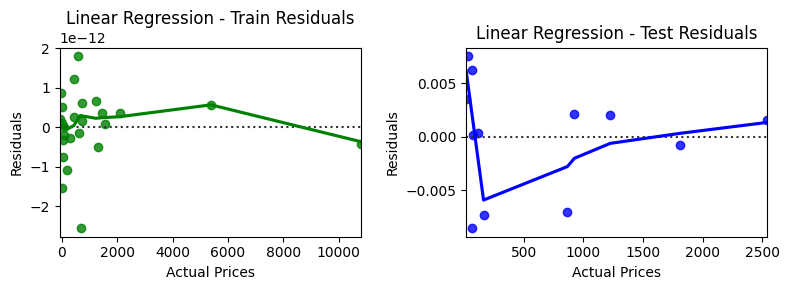

Training Decision Tree...


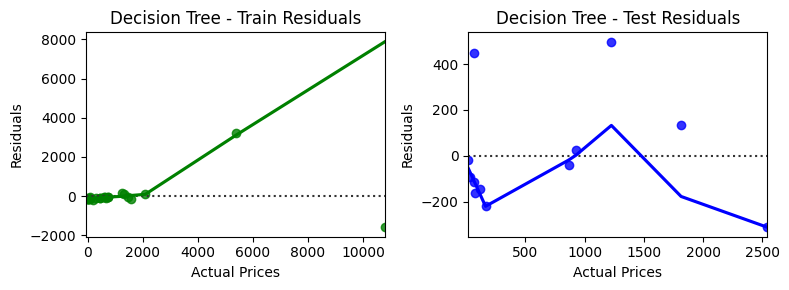

Training K-Nearest Neighbors...


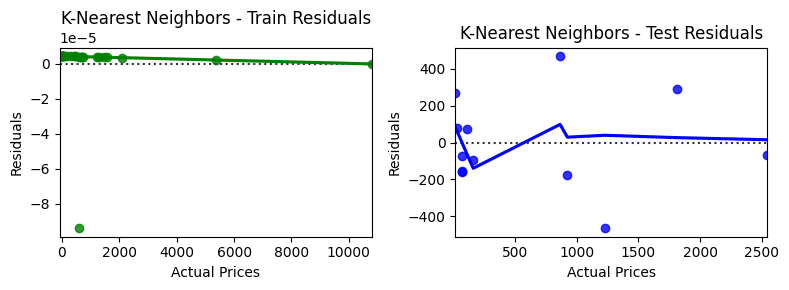

Training Random Forest...


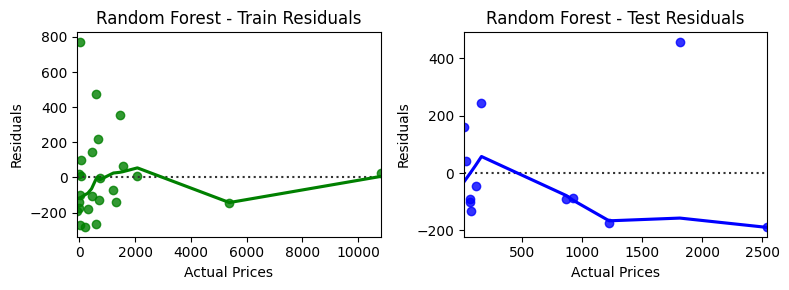

Training Gradient Boosting...


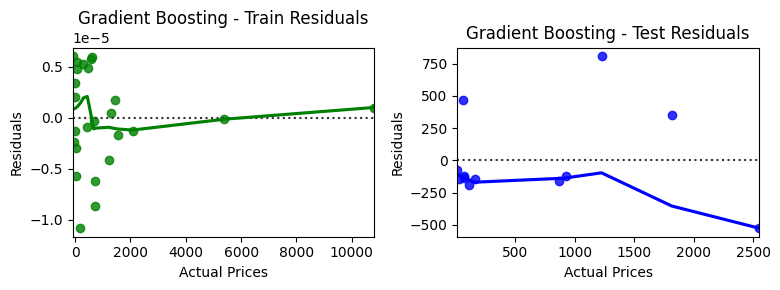

Training AdaBoost...


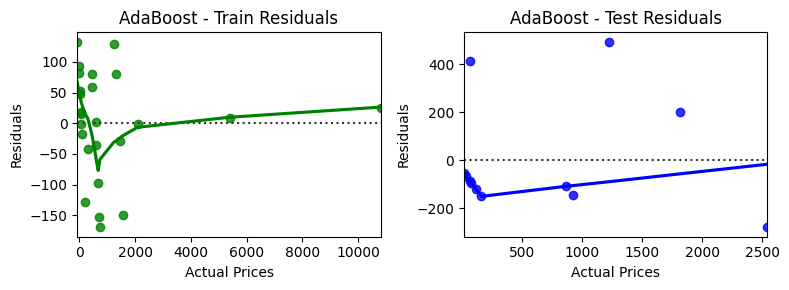

In [136]:
X = model_data.drop(columns=['price_difference'])
y = model_data['price_difference']

results_df = train_and_evaluate_models(X, y, importances=False)

In [137]:
results_df

,Model,Best Params,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2
0,Linear Regression,"{'fit_intercept': False, 'positive': False}",1.351364e-12,0.005008,1.036344e-12,0.003968,1.000000,1.000000
1,Decision Tree,"{'criterion': 'squared_error', 'max_depth': No...",7.690698e+02,408.610715,2.521667e+02,263.250000,0.884247,0.740150
2,K-Nearest Neighbors,"{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}",1.962352e-05,461.073194,3.924705e-06,326.743754,1.000000,0.669141
3,Random Forest,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",7.959828e+02,551.439233,4.487750e+02,461.324444,0.876003,0.526741
4,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",4.971344e-06,397.785724,4.172606e-06,252.253254,1.000000,0.753736
5,AdaBoost,"{'learning_rate': 0.1, 'n_estimators': 200}",8.443540e+01,374.899600,6.588657e+01,243.757029,0.998605,0.781258


Part E – perform Reverse Engineering to the sorting algorithms of the websites
- Note that in default (without choosing the sorting option in the website) – the 
website shows results in specific order by different considerations. The 
location of the hotel in the results page can be affected for example from the 
hotel ratings, location, number of reviews and more. You have to plan and 
implement solution that will allow (based on the data you downloaded in Part 
A) to sort yourself the results page. In order to do it, you have to use learning 
techniques you learnt in the course.
- In order to evaluate the sorting algorithm performance you created, the train 
data must contain all data for even TTT values, and the Test data must 
contain all the data for odd TTT values.
- For test evaluation of the sorting algorithm you built, you first have to perform 
random shuffle on the Test data and then given the algorithm you built to 
resort. The error size of your algorithm on given page you will measure using 
the sum squared of indexes difference of the search result on given page. 
After that, you have to show the average and standard deviation of the errors 
you got for all Test pages

In [205]:
import pandas as pd

# Load data
original_booking_data = pd.read_csv('scraped_data/booking_data.csv')
original_expedia_data = pd.read_csv('scraped_data/expedia_data.csv')

original_booking_data = original_booking_data.drop(columns=['Card Deal', 'Cancellation Policy', 'Payment Policy'])
original_booking_data = original_booking_data.dropna(subset=['Stars', 'Bed Type'])

original_expedia_data = original_expedia_data.drop(columns=['Room Type', 'Bed Type', 'Cancellation Policy', 'Payment Policy'])
original_expedia_data = original_expedia_data.dropna(subset=['Classification'])
original_expedia_data['Price Before Taxes'] = original_expedia_data['Price Before Taxes'].str.replace(',', '', regex=False).astype(float)
original_booking_data['Price'] = original_booking_data['Price'].astype(float)
original_booking_data['Taxes and Fees'] = original_booking_data['Taxes and Fees'].astype(float)
original_booking_data['Total Price'] = original_booking_data['Total Price'].astype(float)

# Selecting only columns that are in both dataframes
common_columns = list(set(original_booking_data.columns) & set(original_expedia_data.columns))
expedia_data = original_expedia_data[common_columns]
booking_data = original_booking_data[common_columns]

expedia_columns = [col.replace(' ', '_').lower() for col in expedia_data.columns]
booking_data.columns = expedia_columns
expedia_data.columns = expedia_columns

In [206]:
expedia_data

,los,classification,ttt,number_of_reviews,neighborhood,checkin,total_price,checkout,hotel_name,date_of_search,score
0,1,Exceptional,1,497,Williamsburg,2024-06-21,281,2024-06-22,Penny Williamsburg,2024-06-20,9.6
1,1,Excellent,1,1002,Chelsea,2024-06-21,286,2024-06-22,Moxy NYC Chelsea,2024-06-20,8.6
2,1,Wonderful,1,1003,Chelsea,2024-06-21,258,2024-06-22,Courtyard by Marriott New York Manhattan / Che...,2024-06-20,9.2
3,2,Exceptional,1,497,Williamsburg,2024-06-21,281,2024-06-23,Penny Williamsburg,2024-06-20,9.6
4,2,Excellent,1,1002,Chelsea,2024-06-21,286,2024-06-23,Moxy NYC Chelsea,2024-06-20,8.6
...,...,...,...,...,...,...,...,...,...,...,...
38772,5,Very Good,30,1004,New York,2024-08-03,261,2024-08-08,Ace Hotel New York,2024-07-04,8.2
38773,5,Excellent,30,274,New York,2024-08-03,207,2024-08-08,The Flat NYC,2024-07-04,8.6
38774,5,Excellent,30,1926,Chelsea,2024-08-03,272,2024-08-08,Chelsea Savoy Hotel,2024-07-04,8.6
38775,5,Good,30,2340,New York,2024-08-03,296,2024-08-08,Millennium Downtown New York,2024-07-04,7.4


In [207]:
# Encode categorical columns
categorical_columns = ['hotel_name', 'neighborhood']

# Use LabelEncoder for hotel_name since it is a unique identifier
label_encoder = LabelEncoder()
expedia_data['hotel_name'] = label_encoder.fit_transform(expedia_data['hotel_name'])
booking_data['hotel_name'] = label_encoder.fit_transform(booking_data['hotel_name'])

# Use OneHotEncoder for neighborhood columns
one_hot_encoder = OneHotEncoder(drop='first')

# Encode 'neighborhood_booking'
neighborhood_booking_encoded = one_hot_encoder.fit_transform(booking_data[['neighborhood']])
neighborhood_booking_features = ['neighborhood' + feature for feature in one_hot_encoder.get_feature_names_out()]
neighborhood_booking_df = pd.DataFrame(neighborhood_booking_encoded.toarray(), columns=neighborhood_booking_features)

neighborhood_expedia_encoded = one_hot_encoder.fit_transform(expedia_data[['neighborhood']])
neighborhood_expedia_features = ['neighborhood' + feature for feature in one_hot_encoder.get_feature_names_out()]
neighborhood_expedia_df = pd.DataFrame(neighborhood_expedia_encoded.toarray(), columns=neighborhood_expedia_features)

# Reset indices to match the original DataFrame
neighborhood_booking_df = neighborhood_booking_df.reset_index(drop=True)
neighborhood_expedia_df = neighborhood_expedia_df.reset_index(drop=True)

# Concatenate the original DataFrame with the encoded columns
booking_data = pd.concat([booking_data, neighborhood_booking_df], axis=1)
expedia_data = pd.concat([expedia_data, neighborhood_expedia_df], axis=1)

booking_data.drop('neighborhood', axis=1, inplace=True)
expedia_data.drop('neighborhood', axis=1, inplace=True)

In [208]:
expedia_data['classification'] = expedia_data['classification'].map(ordinal_mapping_expedia)
booking_data['classification'] = booking_data['classification'].map(ordinal_mapping_booking)

In [209]:
expedia_data.dropna(inplace=True)
booking_data.dropna(inplace=True)

In [210]:
# # Create a combined column for date range if necessary
# booking_data['Date Range'] = booking_data['checkin'] + ' to ' + booking_data['checkout']
# expedia_data['Date Range'] = expedia_data['checkin'] + ' to ' + expedia_data['checkout']

In [211]:
# Split the data
train_booking_data = booking_data[booking_data['ttt'] % 2 == 0]
test_booking_data = booking_data[booking_data['ttt'] % 2 != 0]

train_expedia_data = expedia_data[expedia_data['ttt'] % 2 == 0]
test_expedia_data = expedia_data[expedia_data['ttt'] % 2 != 0]

In [212]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the target and features
target_booking = 'total_price'
target_expedia = 'total_price'

features_booking = [col for col in train_booking_data.columns if col not in ['total_price', 'date_of_search', 'checkin', 'checkout', 'ttt', 'los']]
features_expedia = [col for col in train_expedia_data.columns if col not in ['total_price', 'date_of_search', 'checkin', 'checkout', 'ttt', 'los']]

# Initialize the model
model_booking = RandomForestRegressor()
model_expedia = RandomForestRegressor()

# Fit the model
model_booking.fit(train_booking_data[features_booking], train_booking_data[target_booking])
model_expedia.fit(train_expedia_data[features_expedia], train_expedia_data[target_expedia])

# Predict
predictions_booking = model_booking.predict(test_booking_data[features_booking])
predictions_expedia = model_expedia.predict(test_expedia_data[features_expedia])

# Evaluate
error_booking = np.sqrt(mean_squared_error(test_booking_data[target_booking], predictions_booking))
error_expedia = np.sqrt(mean_squared_error(test_expedia_data[target_expedia], predictions_expedia))

print(f'Booking.com Model Error: {error_booking}')
print(f'Expedia Model Error: {error_expedia}')


Booking.com Model Error: 1009.1949505488725
Expedia Model Error: 7.876371810312947


In [213]:
import random

# Shuffle test data
test_booking_data = test_booking_data.sample(frac=1).reset_index(drop=True)
test_expedia_data = test_expedia_data.sample(frac=1).reset_index(drop=True)

# Predict on shuffled data
shuffled_predictions_booking = model_booking.predict(test_booking_data[features_booking])
shuffled_predictions_expedia = model_expedia.predict(test_expedia_data[features_expedia])

# Calculate the sum of squared index differences
index_diff_booking = (test_booking_data.index - shuffled_predictions_booking)**2
index_diff_expedia = (test_expedia_data.index - shuffled_predictions_expedia)**2

# Calculate average and standard deviation of errors
avg_error_booking = np.mean(index_diff_booking)
std_dev_error_booking = np.std(index_diff_booking)

avg_error_expedia = np.mean(index_diff_expedia)
std_dev_error_expedia = np.std(index_diff_expedia)

print(f'Booking.com Average Error: {avg_error_booking}, Standard Deviation: {std_dev_error_booking}')
print(f'Expedia Average Error: {avg_error_expedia}, Standard Deviation: {std_dev_error_expedia}')


Booking.com Average Error: 4067910.48913839, Standard Deviation: 4764017.788076686
Expedia Average Error: 118521367.20444158, Standard Deviation: 107761240.05750395
